In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json
import importlib


device = torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet

In [2]:
buildData=False
datadir = '/home/ephy/Projects/tda_convolution/data/original/CIFAR/cifar-10-batches-py/'
if buildData:
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    train_X = list()
    train_y = list()
    for batch in os.listdir(datadir):
        if 'data_batch' in batch:
            resp = unpickle(datadir+batch)
            for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
                train_X.append(np.moveaxis(item,0,-1)/255)
                train_y.append(resp[b'labels'][i])
    train_X = np.array(train_X)
    train_y = np.array(train_y)

    test_X = list()
    test_y = list()
    resp=unpickle(datadir+'test_batch')
    for i, item in enumerate(resp[b'data'].reshape(-1,3,32,32)):
        test_X.append(np.moveaxis(item,0,-1)/255)
        test_y.append(resp[b'labels'][i])

    test_X = np.array(test_X)
    test_y = np.array(test_y)

    nClasses=len(np.unique(train_y))
    test_y = np.array([np.eye(nClasses)[x] for x in test_y])
    train_y = np.array([np.eye(nClasses)[x] for x in train_y])
    
    np.save('../data/altered/CIFAR/train_X_color' , train_X)
    np.save('../data/altered/CIFAR/train_y_color' , train_y)
    np.save('../data/altered/CIFAR/test_X_color' , test_X)
    np.save('../data/altered/CIFAR/test_y_color' , test_y)
    
train_X=np.load('../data/altered/CIFAR/train_X_color.npy' )
train_y=np.load('../data/altered/CIFAR/train_y_color.npy' )
test_X=np.load('../data/altered/CIFAR/test_X_color.npy' )
test_y=np.load('../data/altered/CIFAR/test_y_color.npy' )
    
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

In [3]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'
device = torch.device("cuda:0")

class DogsVSCats():
    IMG_SIZE = 32
    CATS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = datadir + "original/kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])                  
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                            
                except Exception as e:
                    #print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save(datadir + "altered/catdog_training_data_32x32_color.npy", self.training_data)
        
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
training_data = np.load(datadir+"altered/catdog_training_data_32x32_color.npy", allow_pickle=True)

X = np.array([i[0] for i in training_data])
kaggle_cd_X = X/255.0
kaggle_cd_y = np.array([i[1] for i in training_data])
kaggle_cd_X = kaggle_cd_X.astype(np.float32)
kaggle_cd_y = kaggle_cd_y.astype(np.float32)

kaggle_cd_X = torch.tensor(kaggle_cd_X)
kaggle_cd_y = torch.tensor(kaggle_cd_y)

In [4]:
import torchvision.models as models

In [5]:
class AddaptedVGG(nn.Module):
    def __init__(self):
        super(AddaptedVGG,self).__init__()
        self.net = models.vgg16(pretrained=True)
        for param in self.net.features.parameters():
            param.requires_grad = False
        for i,param in enumerate(self.net.classifier.parameters()):
            param.requires_grad = False
        self.net.classifier[6] = nn.Linear(4096,10)


    def forward(self,x):
        x = self.net(x)
        return x

net = AddaptedVGG().to(device)

optimizer = optim.Adam(net.parameters(), lr=1e-5)

In [127]:
for i,p in enumerate(net.net.classifier.parameters()):
    print(p.requires_grad)

False
False
False
False
True
True


In [128]:
batchSize=1000
imageDim=(32,32)
accuracies = []
losses=[]
epochs=1
for epoch in range(epochs):
    for n in range(0, len(train_X), batchSize):
        batch_X = train_X[n:n+batchSize].view(-1,3,imageDim[0],imageDim[1]).to(device)
        batch_y = train_y[n:n+batchSize].to(device)
        net.zero_grad()
        outputs = net(batch_X)
        loss = nn.MSELoss()(outputs, batch_y)
        losses.append(loss.tolist())
        loss.backward()
        optimizer.step()


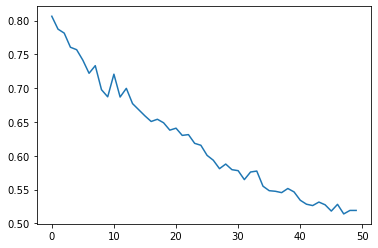

In [129]:
plt.plot(losses)

In [7]:
def test(net, test_X, test_y):
    correct  = 0
    total = 0
    with torch.no_grad():
        for n in range(0, len(test_X), batchSize):
            net_out = net(test_X[n:n+batchSize].view(-1,3,imageDim[0],imageDim[1]).to(device))
            for i, x in enumerate(net_out):
                if torch.argmax(test_y[n:n+batchSize][i])==torch.argmax(x):
                    correct +=1
                total +=1
    return(correct/total)

In [10]:
# 5's are dogs and 3's are cats in CIFAR 10
# 0's are cats 1's are dogs in kaggle
def switcher(n):
    if np.all(n==np.array([1,0])):
        return(np.eye(10)[3])
    return(np.eye(10)[5])
kaggle_test_y = torch.tensor(np.array([switcher(x) for x in np.array(kaggle_cd_y)]), dtype=torch.float32)
sample = np.round(np.random.uniform(0, len(kaggle_test_y),1000),0).astype(np.int)
kaggle_test_y=kaggle_test_y[sample]
kaggle_test_X=kaggle_cd_X[sample]

In [24]:
# plt.imshow(np.array(kaggle_cd_X[18000])) # cat for sure!
# plt.show()
# kaggle_test_y[18000]
# plt.imshow(np.array(kaggle_cd_X[19000])) # dog for sure!
# plt.show()
# kaggle_test_y[19000]
net.net.features[2].weight.shape

torch.Size([64, 64, 3, 3])

In [25]:
class AddaptedVGG(nn.Module):
    def __init__(self):
        super(AddaptedVGG,self).__init__()
        self.net = models.vgg16(pretrained=False)
        for i, param in enumerate(self.net.features.parameters()):
            if i<1: param.requires_grad = False
        self.net.classifier[6] = nn.Linear(4096,10)

    def forward(self,x):
        x = self.net(x)
        return x

net = AddaptedVGG().to(device)

colorprops = [0.299, 0.587, 0.114]
with torch.no_grad():
    klein_filters = topnet.legendre_klein_bottle(8,8,3,None)
    for n in range(net.net.features[0].weight.shape[0]):
        for i in range(3):
            net.net.features[0].weight[n,i] = torch.nn.Parameter(torch.tensor(klein_filters[n]*colorprops[i])).to(device)
#             net.net.features[2].weight[n] = torch.nn.Parameter(torch.tensor(klein_filters[n])).to(device)
            
optimizer = optim.Adam(net.parameters(), lr=1e-5)

In [26]:
batchSize=100
imageDim=(32,32)
klein_accuracies = []
klein_kaggle_accuracies = []
klein_losses=[]
epochs=1
for epoch in range(epochs):
    for n in range(0, len(train_X), batchSize):
        batch_X = train_X[n:n+batchSize].view(-1,3,imageDim[0],imageDim[1]).to(device)
        batch_y = train_y[n:n+batchSize].to(device)
        net.zero_grad()
        outputs = net(batch_X)
        loss = nn.MSELoss()(outputs, batch_y)
        klein_losses.append(loss.tolist())
        loss.backward()
        optimizer.step()
        if n%5000==0:
            klein_accuracies.append(test(net, test_X,test_y))
            klein_kaggle_accuracies.append(test(net, kaggle_test_X,kaggle_test_y))

In [21]:
class AddaptedVGG(nn.Module):
    def __init__(self):
        super(AddaptedVGG,self).__init__()
        self.net = models.vgg16(pretrained=False)
        self.net.classifier[6] = nn.Linear(4096,10)

    def forward(self,x):
        x = self.net(x)
        return x

normal_net = AddaptedVGG().to(device)

normal_optimizer = optim.Adam(normal_net.parameters(), lr=1e-5)

In [22]:
batchSize=100
imageDim=(32,32)
accuracies = []
kaggle_accuracies = []
losses=[]
epochs=1
for epoch in range(epochs):
    for n in range(0, len(train_X), batchSize):
        batch_X = train_X[n:n+batchSize].view(-1,3,imageDim[0],imageDim[1]).to(device)
        batch_y = train_y[n:n+batchSize].to(device)
        normal_net.zero_grad()
        outputs = normal_net(batch_X)
        loss = nn.MSELoss()(outputs, batch_y)
        losses.append(loss.tolist())
        loss.backward()
        normal_optimizer.step()
        if n%5000==0:
            accuracies.append(test(normal_net, test_X,test_y))
            kaggle_accuracies.append(test(normal_net, kaggle_test_X,kaggle_test_y))

** Note about color vs grayscale

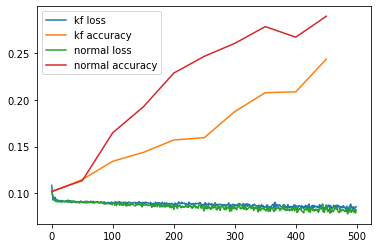

In [27]:
plt.plot(klein_losses, label = 'kf loss')
plt.plot(np.arange(len(klein_accuracies))*50,klein_accuracies, label='kf accuracy')
plt.plot(losses, label = 'normal loss')
plt.plot(np.arange(len(accuracies))*50,accuracies, label='normal accuracy')
# plt.plot(np.arange(len(klein_kaggle_accuracies))*5,klein_kaggle_accuracies, label='klein x-acc')
# plt.plot(np.arange(len(kaggle_accuracies))*10,kaggle_accuracies, label='normal x-acc')
plt.legend()
# plt.title('Klein')
plt.show()

In [228]:
torch.cuda.empty_cache()